<a id="top"></a>
# Look For Transients In FFI's In Nearby Galaxies
***

## Prerequisites
- Basic Python syntax, such as WHAT
- Familiarity with types of [extragalactic transients](https://astrobites.org/2022/10/30/guide-to-transient-astronomy/)

## Learning Goals

Original description: "Use FFI cutout tool to extract areas centered on nearby galaxies to search for extragalactic transients north of -30 degrees. The declination limit is chosen so that higher resolution PanSTARRS data are also available for post-detection analysis."

By the end of this tutorial, you will:

- Maybe something about narrowing down the list of possible targets? Do we want these nearby so they are resolved?
- Use the TESScut feature of astroquery to find a full-frame image time series of a nearby galaxy.
- Use something, lightkurve maybe? to determine if a transient event occured in the galaxy
- Maybe also check if PanSTARRS data is also available - but what to do with it?

## Introduction

Basic draft:
- TESS for searching for exoplanets, but galaxies also contained in the images, can be examined over times.
- Since 2018, TESS has been observing all parts of the sky, with particular overlapping coverage near the ecliptic poles. We will focus on data visible from the Northern hemisphere, so that there may be Pan-STARRS data for further analysis. SO WHICH YEARS NORTHERN DATA
- Transients (link) such as SN so bright (numbers), notable in the time series brightness of the galaxy (are we doing galaxy-integrated counts?)
- 

IS THIS OKAY OR DO WE WANT A SEPARATE TOC SECTION?

The workflow for this notebook consists of:
* [Main Content](#Main-Content)
    * [Loading Data](#Loading-Data)
    * [File and Data Information](#File-and-Data-Information)
* [Visualization](#Visualization)
* [Exercises](#Exercises)
* [Additional Resources](#Additional-Resources)

## Imports

HAVEN'T EDITED YET
Describe the main packages we're using here and their use-case for this notebook. If there's something unusual, explain what the library is, and why we need it.
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *matplotlib.pyplot* for plotting data

In [135]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astroquery.mast import Mast
from astroquery.mast import Observations

# Added by JRK
from astroquery.mast import Tesscut
from astropy.visualization import time_support
import lightkurve as lk
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord

***

# Headers Here

## Looking for needles in haystacks...

In [2]:
# My code that's just playing around for now.
objname = 'M85' # Supernova on June 25th, 2020. https://skyandtelescope.org/astronomy-news/bright-supernovae-light-up-nearby-galaxies/  

sector_table = Tesscut.get_sectors(objectname=objname)
print(sector_table)
# Sector 49 corresponds to Feb 26 - Mar 26, 2022, so would not catch the supernova. How to view sector info by time?
# https://heasarc.gsfc.nasa.gov/docs/tess/sector.html

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0049-1-1     49      1   1


In [3]:
objname = 'NGC4457' # Supernova on July 1, 2020. 

sector_table = Tesscut.get_sectors(objectname=objname)
print(sector_table)

# Sector 23 was apparently Mar 19 - Apr 15, 2020 - just too early!
# Sector 46 was Dec 02 - Dec 30, 2021 (typo on the website?)
# https://heasarc.gsfc.nasa.gov/docs/tess/sector.html


  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0023-1-3     23      1   3
tess-s0046-4-1     46      4   1


In [4]:
hdulist = Tesscut.get_cutouts(objectname=objname, size=10)
print('Length of hdulist =',len(hdulist))

Length of hdulist = 2


Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      57   ()      
  1  PIXELS        1 BinTableHDU    281   3707R x 12C   [D, E, J, 100J, 100E, 100E, 100E, 100E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        82   (10, 10)   int32   


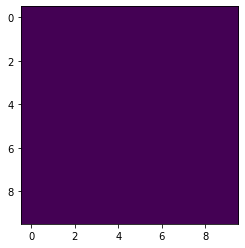

In [5]:
hdulist[1].info()
plt.imshow(hdulist[1][2].data)

## Using ZTF list already pre-sorted by those with TESS

https://ui.adsabs.harvard.edu/abs/2020AAS...23515709P/abstract

https://sites.astro.caltech.edu/ztf/bts 

In [117]:
tab=Table.read('ZTF_brightSN_TESS.csv')

In [118]:
i=1
row=tab[i]
objname=row['IAUID']
print(row)
hostgal='MCG+08-33-046'

   ZTFID       IAUID        RA         Dec     peakt  peakfilt peakmag peakabs duration  rise   fade   type redshift      b       A_V 
------------ --------- ----------- ----------- ------ -------- ------- ------- -------- ------ ------ ----- -------- ----------- -----
ZTF19aamhqej SN2019bvt 18:28:48.43 +50:22:23.4 573.01        g 15.4052   -19.1    21.52 10.257 11.263 SN Ia   0.0169 24.02698859 0.158


In [119]:
row['fade']

'11.263'

In [120]:
# Peak time
t = Time(row['peakt']+2458000, format='jd', scale='utc')
t.ymdhms
# Time at half of peak while rising
thalf1=t-row['rise']*u.d
# Time at half of peak while fading
thalf2=float(row['fade'])*u.d+t # For some reason, 'fade' is a string

## Trying to search for observations with the right timing

In [122]:
tab.add_column(np.zeros(len(tab),dtype=int),name='nTESS')

In [131]:
tab.add_column(np.zeros(len(tab),dtype=int),name='nTESStimed')

In [123]:
to_mjd=2400000.5

In [129]:
row['RA']+row['Dec']

'18:28:48.43+50:22:23.4'

In [134]:
obs=Observations.query_criteria(coordinates=row['RA']+' '+row['Dec'],
                                                  radius=0.01,
                                                  project='TESS')
obs

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
str7,str4,str4,str10,str4,str4,str7,str8,str1,str25,float64,float64,str5,str17,int64,float64,float64,float64,float64,float64,str1,float64,str3,str1,int64,str128,str1,str1,str6,bool,float64,str9,str9,str9,float64
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0017-2-4,15.363440634174628,45.700650394027726,image,"Ricker, George",3,58764.1915478,58789.19175852,1425.599381,600.0,1000.0,--,58818.3333334,N/A,--,17,POLYGON 11.44401400 37.71599000 3.52035200 48.12225700 21.02048500 53.37500700 25.66793900 42.31845900 11.44401400 37.71599000,--,--,PUBLIC,False,nan,27584813,70752655,70752655,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0018-2-3,26.687089610617615,49.63925022612029,image,"Ricker, George",3,58790.17094,58814.52478767,1425.599399,600.0,1000.0,--,58833.3333334,N/A,--,18,POLYGON 23.82747900 41.74116600 13.50311800 50.76547400 30.82026500 57.72571800 38.75297300 46.83661000 23.82747900 41.74116600,--,--,PUBLIC,False,nan,27620112,70823235,70823235,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0058-2-3,22.17839784481174,49.71061902297847,image,"Ricker, George",3,59881.827729375,59909.55188813657,158.399926,600.0,1000.0,--,59928.0,N/A,--,58,POLYGON 19.844004 41.729485 8.962688 50.414646 25.566801 57.917854 34.495969 47.294485 19.844004 41.729485,--,--,PUBLIC,False,nan,106583808,198035380,198035380,0.0
science,HLSP,TICA,Photometer,TESS,TESS,Optical,TICA FFI,--,hlsp_tica_s0058-cam2-ccd3,22.18733339965266,49.441806127062385,image,Michael Fausnaugh,3,59881.82400960196,59909.5485336706,158.4,600.0,1000.0,--,59913.0,N/A,--,58,POLYGON 19.843496 41.73005 8.961896 50.41366 25.565108 57.915382 34.494489 47.293761 19.843496 41.73005,--,--,PUBLIC,False,nan,100582934,193241207,193241207,0.0


In [139]:
c=SkyCoord(row['RA'],row['Dec'],unit=(u.hourangle,u.deg))
print(c)

<SkyCoord (ICRS): (ra, dec) in deg
    (277.20179167, 50.37316667)>


In [141]:
obs= Observations.query_criteria(coordinates=c,
                                                  radius=0.01,
                                                  project='TESS',target_name='TESS FFI')
obs

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
str7,str4,str4,str10,str4,str4,str7,str8,str1,str14,float64,float64,str5,str14,int64,float64,float64,float64,float64,float64,str1,float64,str3,str1,int64,str133,str1,str1,str6,bool,float64,str8,str9,str9,float64
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0054-3-4,274.9062084331172,47.80025866183014,image,"Ricker, George",3,59769.39685675926,59795.62573140046,475.199781,600.0,1000.0,--,59828.0,N/A,--,54,POLYGON 280.177659 55.653506 286.029228 44.351409 270.673471 39.863156 262.958287 49.979011 280.177659 55.653506,--,--,PUBLIC,False,nan,92616941,176483347,176483347,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0041-2-2,275.3946841989634,54.29451351650317,image,"Ricker, George",3,59419.48662467593,59446.076605358794,475.199767,600.0,1000.0,--,59477.0,N/A,--,41,POLYGON 277.458638 62.727708 289.314286 52.603446 273.615005 45.868863 261.409437 54.31415 277.458638 62.727708,--,--,PUBLIC,False,nan,62870785,118125957,118125957,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0040-2-2,265.3687528501781,54.22242612535834,image,"Ricker, George",3,59390.153316111115,59418.35439530093,475.199784,600.0,1000.0,--,59456.0,N/A,--,40,POLYGON 272.90242 61.740413 277.414555 50.10029 259.807338 46.489641 251.704762 56.838023 272.90242 61.740413,--,--,PUBLIC,False,nan,62431374,117202263,117202263,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0014-2-2,273.2567798635359,54.120767679504056,image,"Ricker, George",3,58682.85500505,58709.68803669,1425.599392,600.0,1000.0,--,58739.3333334,N/A,--,14,POLYGON 276.54966200 62.44606900 286.81593200 51.88773800 270.65934500 45.78306800 259.26875100 54.70272700 276.54966200 62.44606900,--,--,PUBLIC,False,nan,27463639,70511523,70511523,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0055-3-4,287.38158920164466,49.81736384783519,image,"Ricker, George",3,59796.598223078705,59823.76457784722,475.199786,600.0,1000.0,--,59841.0,N/A,--,55,POLYGON 288.806973 58.274901 300.125016 48.436364 285.990144 41.371981 274.752841 49.770071 288.806973 58.274901,--,--,PUBLIC,False,nan,95133384,180182410,180182410,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0026-2-1,281.00057182074477,55.14554410663568,image,"Ricker, George",3,59009.77126432,59034.62568361,1425.599348,600.0,1000.0,--,59064.0,N/A,--,26,POLYGON 293.97118900 59.31346800 288.95748400 48.20880700 270.43683400 49.66541100 270.33190200 61.56974300 293.97118900 59.31346800,--,--,PUBLIC,False,nan,27699642,70982254,70982254,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0025-2-1,271.82027276017874,54.02558566009571,image,"Ricker, George",3,58983.14626804,59008.79236575,1425.599351,600.0,1000.0,--,59050.0,N/A,--,25,POLYGON 285.65074400 55.90984900 276.30067400 46.02241800 259.19345100 50.57084000 265.79864600 61.91175800 285.65074400 55.90984900,--,--,PUBLIC,False,nan,27661254,70905496,70905496,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0053-2-1,282.30932103079607,55.44243012263075,image,"Ricker, George",3,59743.49315427084,59768.479522407404,475.199775,600.0,1000.0,--,59786.0,N/A,--,53,POLYGON 295.079111 59.922744 290.782495 48.707808 272.091874 49.698039 271.004309 61.587936 295.079111 59.922744,--,--,PUBLIC,False,nan,87826071,169467220,169467220,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0052-2-1,273.4056354855315,54.10389449872927,image,"Ricker, George",3,59718.13205803241,59742.57675795139,475.199781,600.0,1000.0,--,59778.0,N/A,--,52,POLYGON 287.147977 56.392517 278.477047 46.242603 261.097035 50.279024 266.55

In [ ]:
obs

In [ ]:
# For each row in the table, record the total number of observations that meet the criteria listed above.
for i,row in enumerate(tab):
    c=SkyCoord(row['RA'],row['Dec'],unit=(u.hourangle,u.deg))
    obs_count1 = Observations.query_criteria_count(coordinates=c,
                                                  radius=0.01,
                                                  project='TESS',
                                                  target_name='TESS FFI')
    obs_count2 = Observations.query_criteria_count(coordinates=c,
                                                  radius=0.01,
                                                  project='TESS',
                                                  target_name='TESS FFI',
                                                  t_min=[thalf1.value-to_mjd,t.value-to_mjd],
                                                  t_max=[t.value-to_mjd,thalf2.value-to_mjd])
    tab['nTESS'][i]=obs_count1
    tab['nTESStimed'][i]=obs_count2
    print(i,obs_count1,obs_count2)
# Resetting what I had done above
i=1
row=tab[i]

0 6 0
1 9 0
2 22 0
3 26 0
4 14 0
5 0 0
6 3 0
7 6 0
8 1 0
9 3 0
10 2 0
11 2 0
12 2 0
13 2 0
14 7 0
15 2 0
16 1 0
17 2 0
18 3 0
19 2 0
20 6 0
21 2 0
22 1 0
23 2 0
24 6 0
25 3 0
26 27 0
27 2 0
28 3 0
29 1 0
30 29 0
31 4 0
32 28 0
33 3 0
34 16 0
35 12 0
36 2 0
37 4 0


## Looking at the observations from one galaxy at a time

In [93]:
sector_table = Tesscut.get_sectors(objectname=row['IAUID'])
print(sector_table)
sector_table2 = Tesscut.get_sectors(objectname=hostgal) # Host galaxy of SN2018hna is UGC07534
print(sector_table2)

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0014-2-2     14      2   2
tess-s0025-2-1     25      2   1
tess-s0026-2-1     26      2   1
tess-s0040-2-2     40      2   2
tess-s0041-2-2     41      2   2
tess-s0052-2-1     52      2   1
tess-s0053-2-1     53      2   1
tess-s0054-3-4     54      3   4
tess-s0055-3-4     55      3   4
  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0014-2-2     14      2   2
tess-s0025-2-1     25      2   1
tess-s0026-2-1     26      2   1
tess-s0040-2-2     40      2   2
tess-s0041-2-2     41      2   2
tess-s0052-2-1     52      2   1
tess-s0053-2-1     53      2   1
tess-s0054-3-4     54      3   4
tess-s0055-3-4     55      3   4


In [98]:
search_result=lk.search_tesscut(hostgal)#objname)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 14,2019,TESScut,1426,MCG+08-33-046,0.0
1,TESS Sector 25,2020,TESScut,1426,MCG+08-33-046,0.0
2,TESS Sector 26,2020,TESScut,1426,MCG+08-33-046,0.0
3,TESS Sector 40,2021,TESScut,475,MCG+08-33-046,0.0
4,TESS Sector 41,2021,TESScut,475,MCG+08-33-046,0.0
5,TESS Sector 52,2022,TESScut,475,MCG+08-33-046,0.0
6,TESS Sector 53,2022,TESScut,475,MCG+08-33-046,0.0
7,TESS Sector 54,2022,TESScut,475,MCG+08-33-046,0.0
8,TESS Sector 55,2022,TESScut,475,MCG+08-33-046,0.0


In [99]:
# Make a note of where they go - mastDownload/HLSP
tpf = search_result.download_all(cutout_size=20)

In [100]:
np.shape(tpf[0].flux)

(1237, 20, 20)

In [101]:
# Is there a pipeline mask? No.
pipeline_mask=tpf[0].pipeline_mask
n_pipeline_pixels = pipeline_mask.sum()
n_pipeline_pixels

0

In [102]:
# Creating mask; one result at a time https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-1-cutting-out-tpfs.html 
target_mask=tpf[0].create_threshold_mask(threshold=3, reference_pixel='center')
n_target_pixels = target_mask.sum()
n_target_pixels

2

<AxesSubplot:title={'center':'Target ID: MCG+08-33-046, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

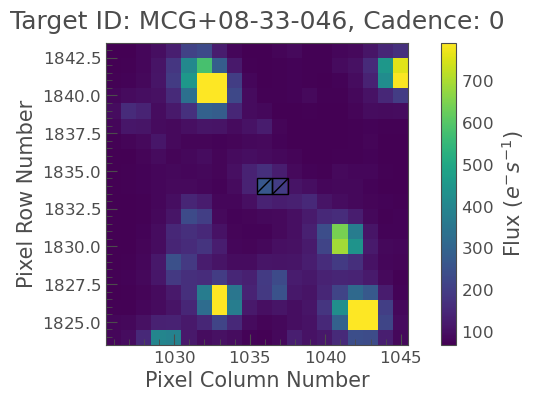

In [103]:
tpf[0].plot(aperture_mask=target_mask, mask_color='k')

In [104]:
target_lc=tpf[0].to_lightcurve(aperture_mask=target_mask)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

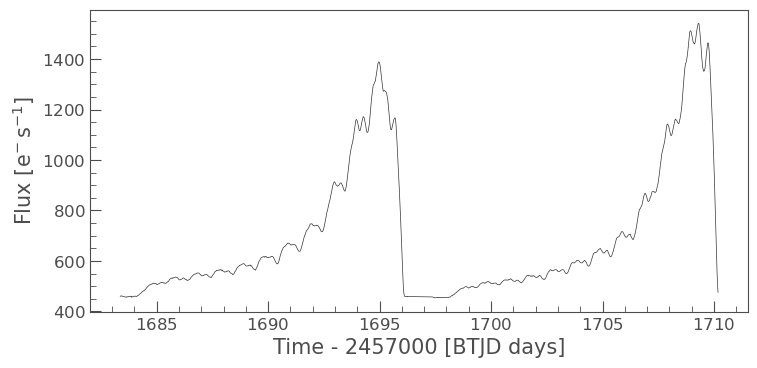

In [105]:
target_lc.plot()

In [106]:
background_mask = ~tpf[0].create_threshold_mask(threshold=0.001, reference_pixel=None)
n_background_pixels = background_mask.sum()
n_background_pixels

201

<AxesSubplot:title={'center':'Target ID: MCG+08-33-046, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

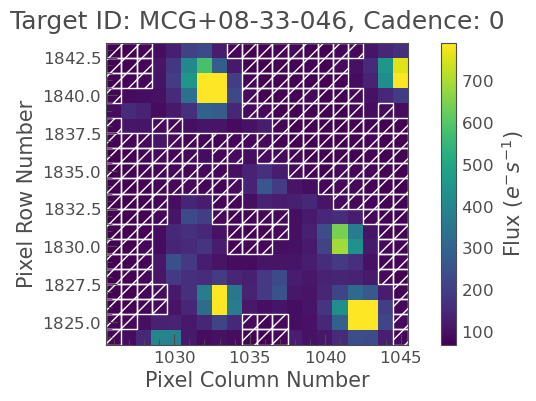

In [107]:
tpf[0].plot(aperture_mask=background_mask,mask_color='w')

In [108]:
background_lc_per_pixel = tpf[0].to_lightcurve(aperture_mask=background_mask) / n_background_pixels

In [109]:
background_estimate_lc = background_lc_per_pixel * n_target_pixels

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

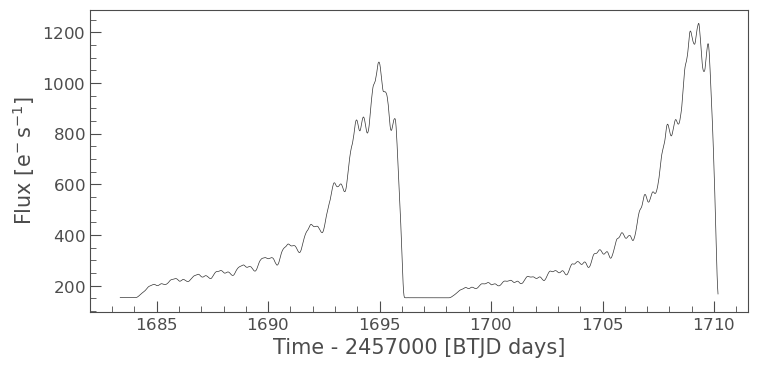

In [110]:
background_estimate_lc.plot()

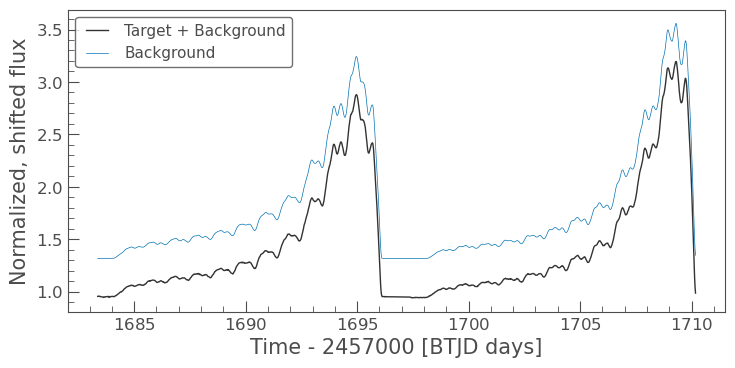

In [111]:
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +1).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');

In [112]:
corrected_lc = target_lc - background_estimate_lc.flux

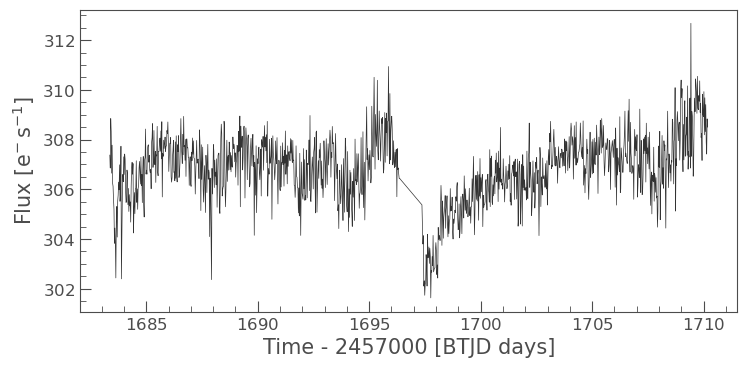

In [113]:
corrected_lc.plot();


9
2
201
6
200
3
200


0
201
2
200
5
201
3
200


/Users/julia/opt/anaconda3/lib/python3.9/site-packages/lightkurve/lightcurve.py:1933: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


4
200
6
200


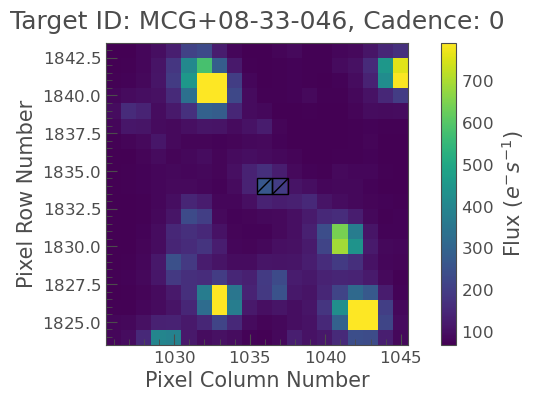

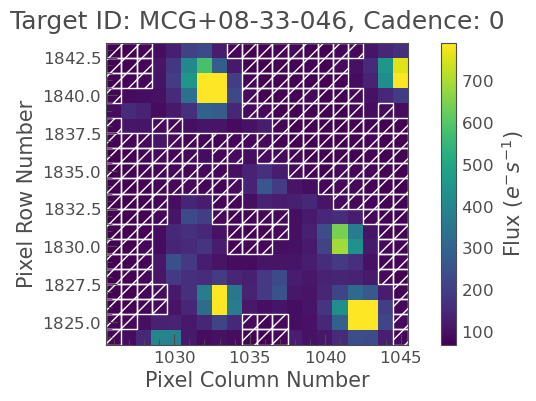

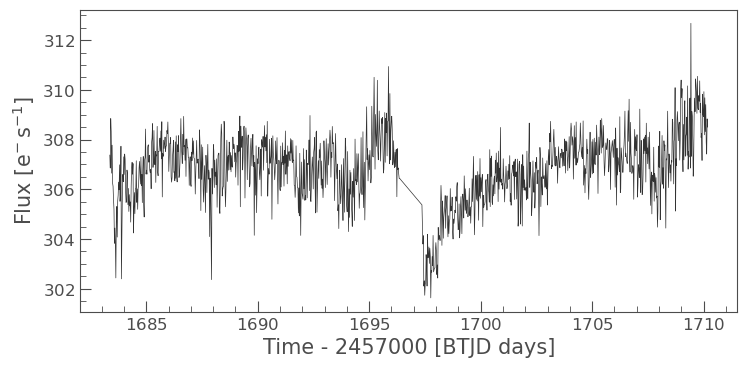

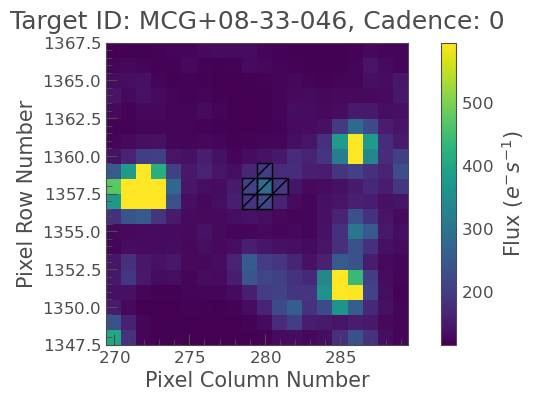

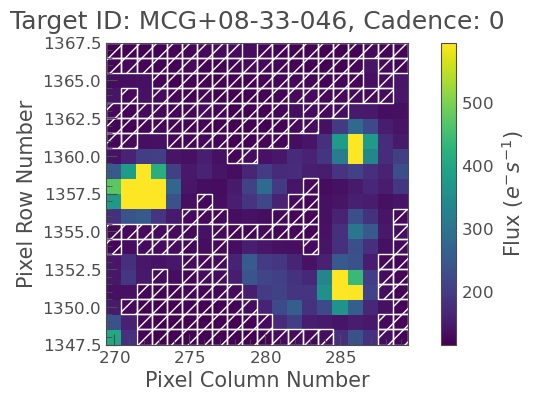

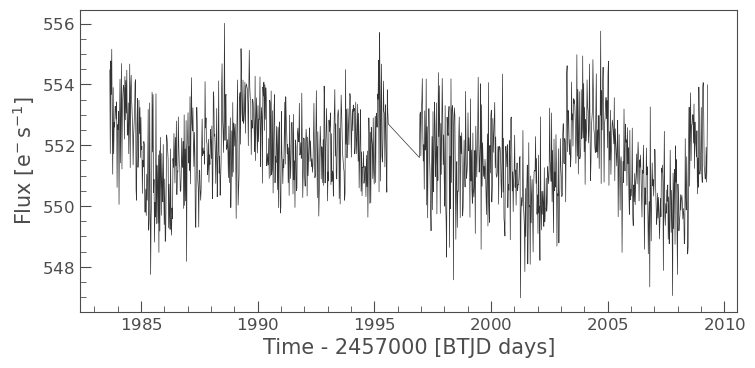

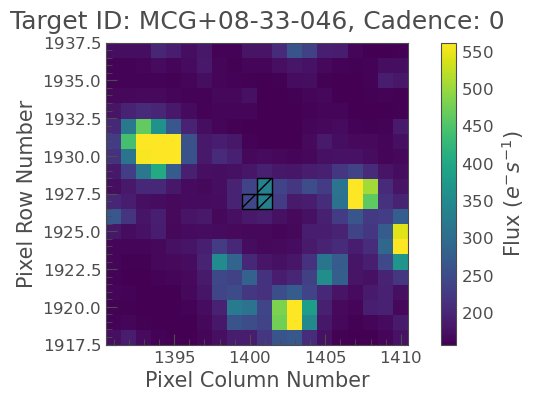

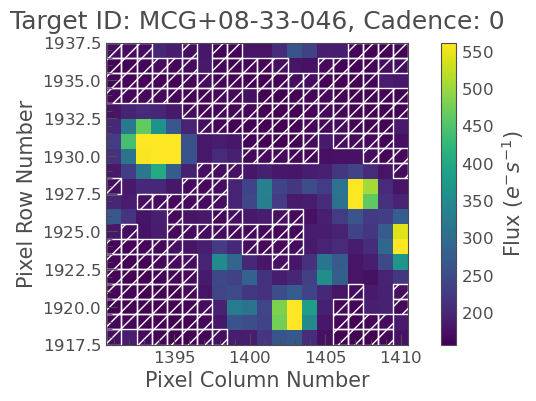

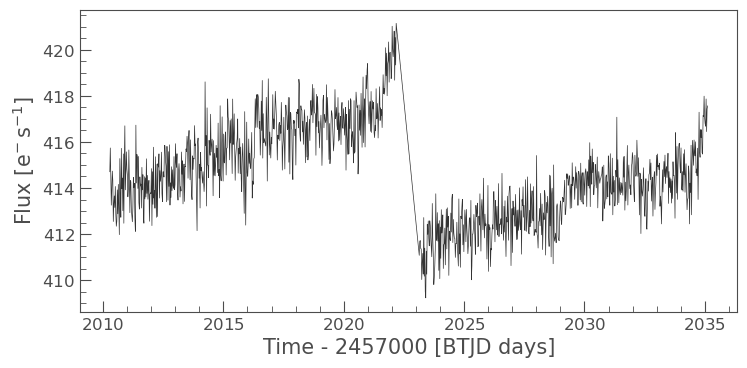

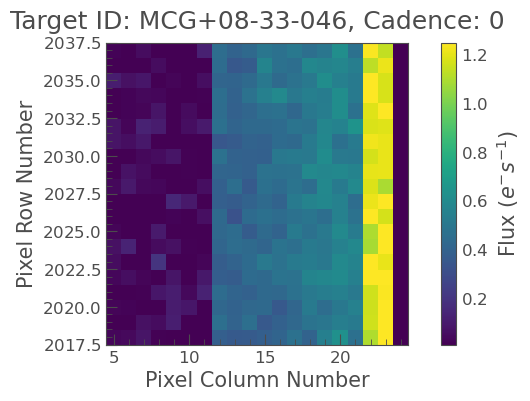

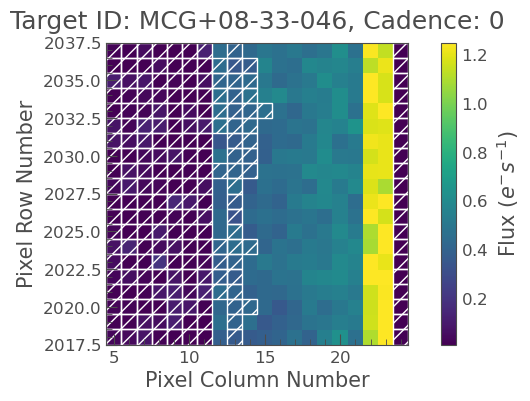

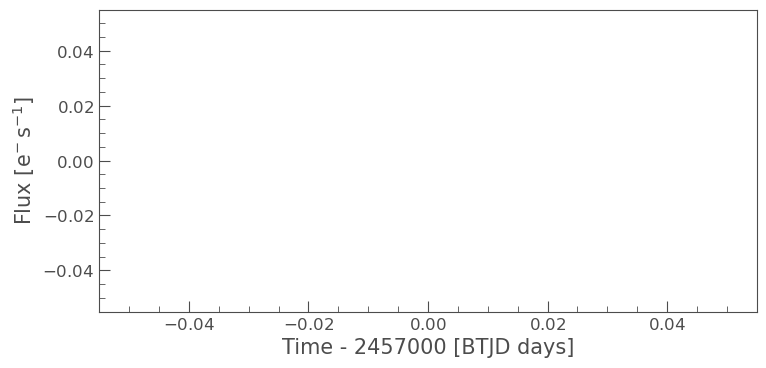

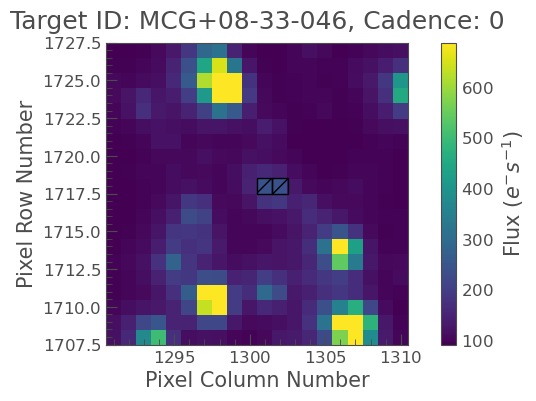

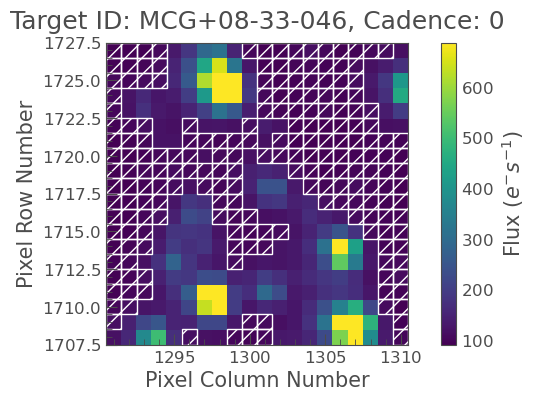

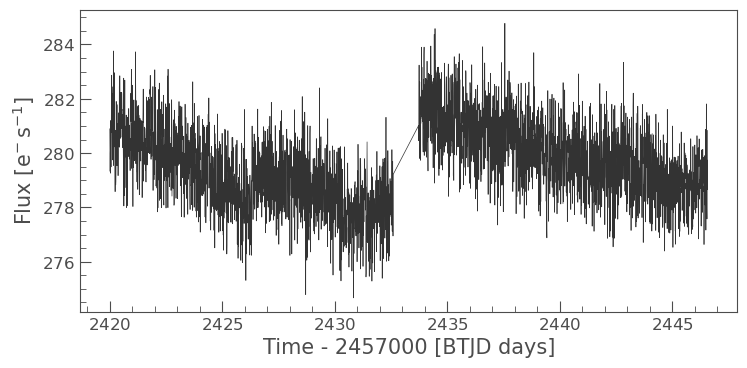

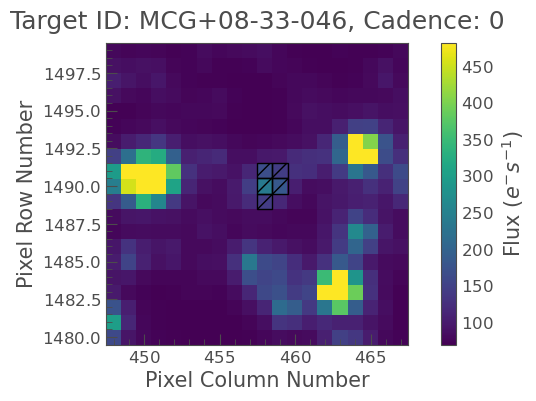

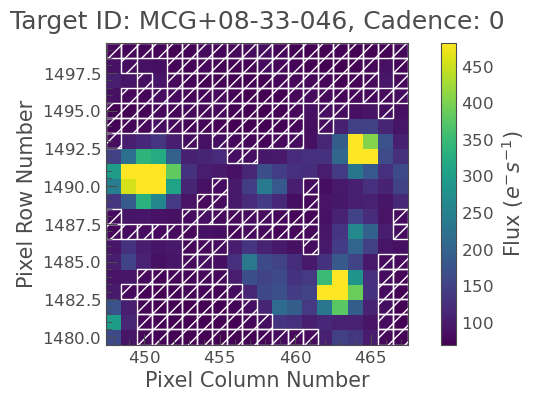

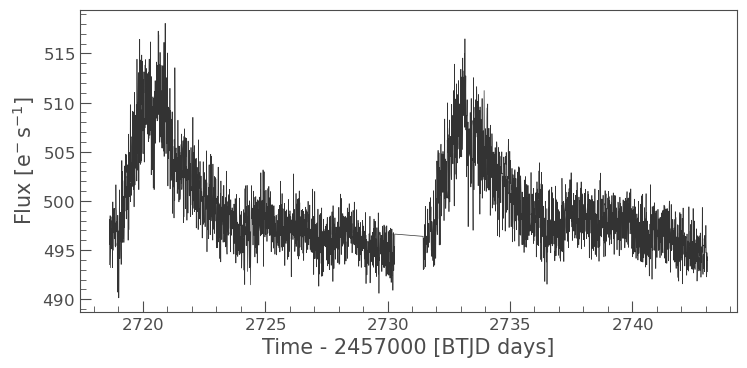

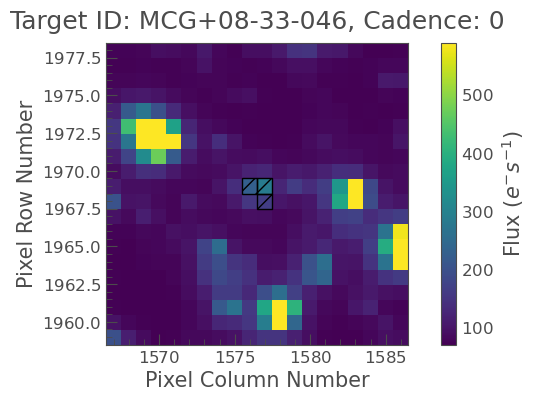

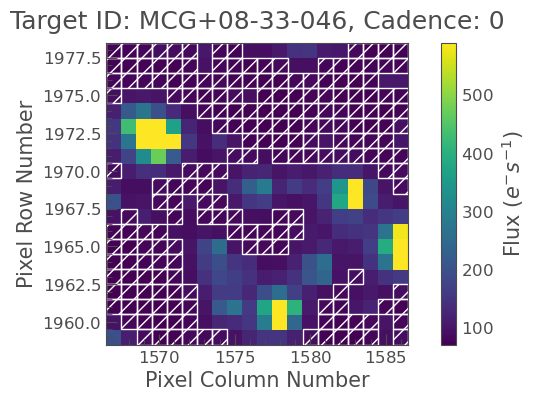

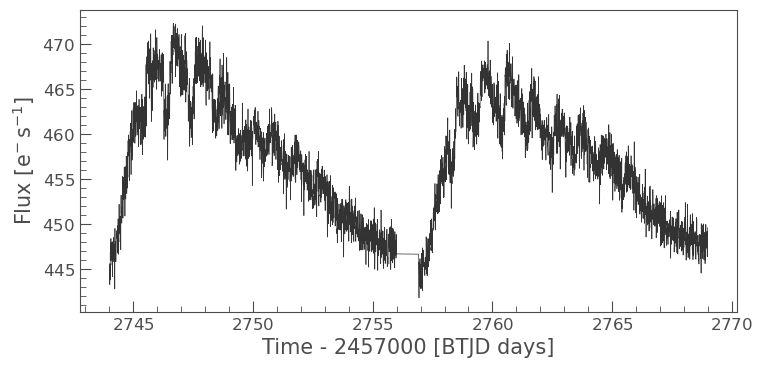

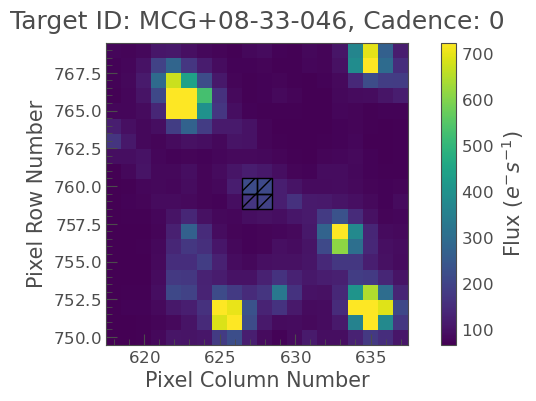

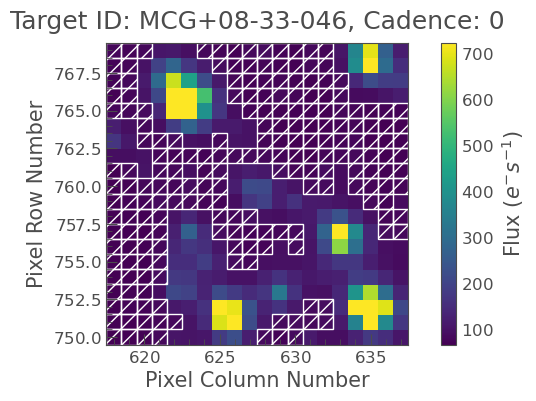

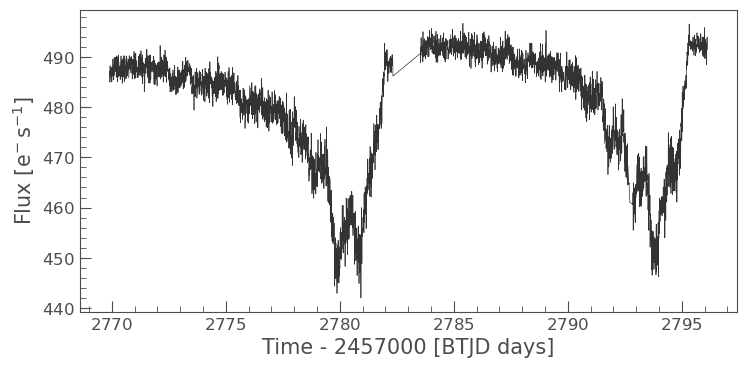

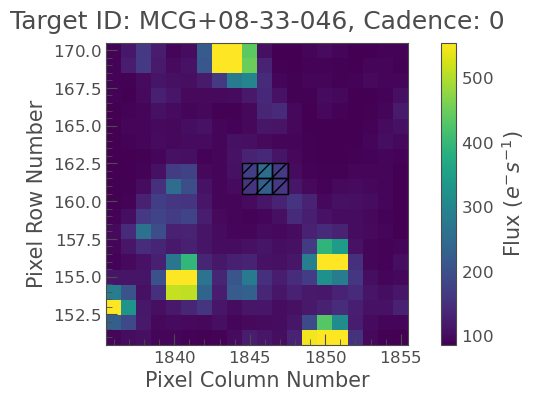

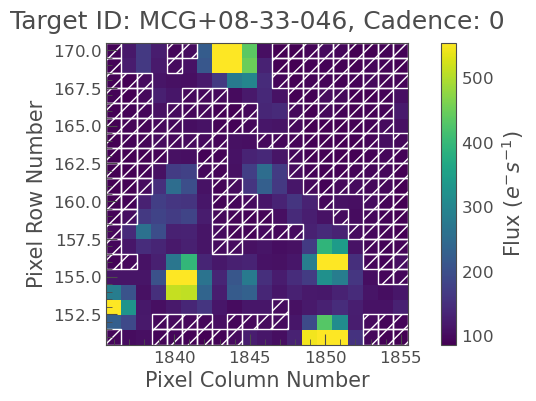

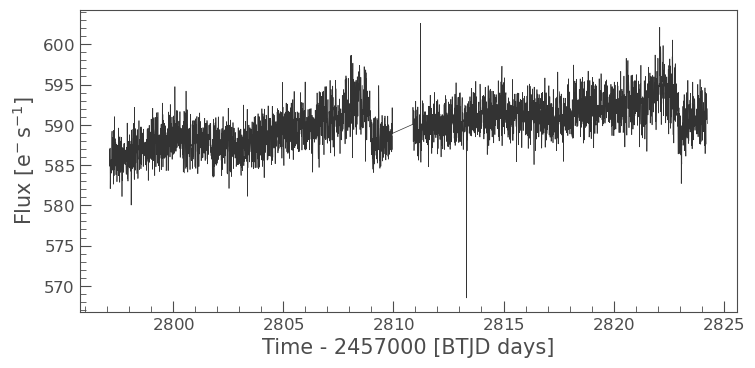

In [114]:
# Basically, we need to get all the TPFs, 
# make an aperture mask for each one, a background mask for each one, a bg-subtracted lightcurve for each one, 
# and then put those lightcurves together as a lightcurve collection
n_sectors=len(tpf)
print(n_sectors)
for j in np.arange(n_sectors):
    target_mask=tpf[j].create_threshold_mask(threshold=3, reference_pixel='center')
    background_mask = ~tpf[j].create_threshold_mask(threshold=0.001, reference_pixel=None)
    
    n_target_pixels = target_mask.sum()
    print(n_target_pixels)
    
    n_background_pixels = background_mask.sum()
    print(n_background_pixels)
    
    target_lc=tpf[j].to_lightcurve(aperture_mask=target_mask)
    
    background_lc_per_pixel = tpf[j].to_lightcurve(aperture_mask=background_mask) / n_background_pixels
    background_estimate_lc = background_lc_per_pixel * n_target_pixels
    
    corrected_lc = target_lc - background_estimate_lc.flux
    
    tpf[j].plot(aperture_mask=target_mask,mask_color='k')
    tpf[j].plot(aperture_mask=background_mask,mask_color='w')
    corrected_lc.plot()
    
    if j==0:
        lc=lk.LightCurveCollection([corrected_lc])
    else:
        lc.append(corrected_lc)

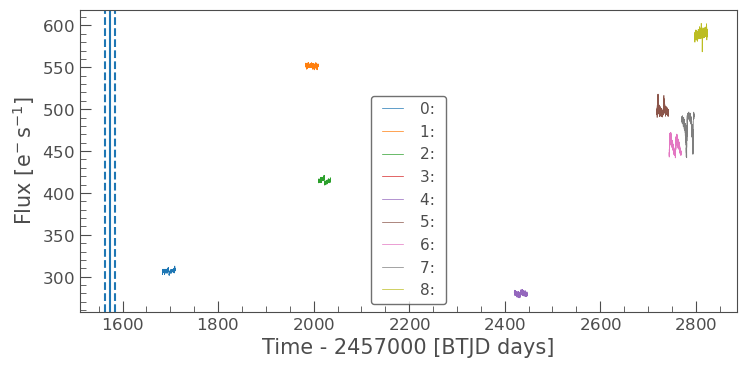

In [115]:
#lc=lk.LightCurveCollection([lc1,lc2])
lc.plot()
plt.axvline(t.jd-2457000,linestyle='solid')
plt.axvline(thalf1.jd-2457000,linestyle='dashed') 
plt.axvline(thalf2.jd-2457000,linestyle='dashed') 

In [116]:
print(lc[0].time)
print(lc[0].time_format)
print(lc[0].time_scale)

[1683.36621094 1683.38702393 1683.40789795 ... 1710.13677979 1710.15759277
 1710.17840576]
btjd
tdb


/var/folders/6d/tr2pz4bs3v76l0_t_5sxy44h0000gn/T/ipykernel_14889/1962944745.py:2: LightkurveDeprecationWarning: The time_format function is deprecated and may be removed in a future version.
        Use time.format instead.
  print(lc[0].time_format)
/var/folders/6d/tr2pz4bs3v76l0_t_5sxy44h0000gn/T/ipykernel_14889/1962944745.py:3: LightkurveDeprecationWarning: The time_scale function is deprecated and may be removed in a future version.
        Use time.scale instead.
  print(lc[0].time_scale)


In [66]:
testt=Time(2458711.38,format='jd',scale='utc')
print(testt.jd)
print(testt.ymdhms)

2458711.38
(2019, 8, 15, 21, 7, 11.99999034)


In [53]:
tpf[4].interact() # Why not working?

<AxesSubplot:title={'center':'Target ID: UGC07534, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

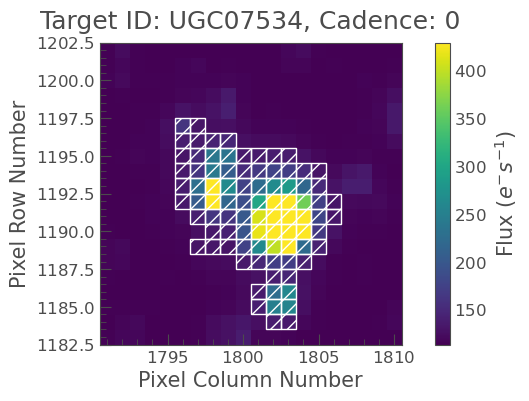

In [51]:
# Creating mask; one result at a time https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-1-cutting-out-tpfs.html 
target_mask=tpf[0].create_threshold_mask(threshold=3, reference_pixel='center')
n_target_pixels = target_mask.sum()
n_target_pixels
tpf[0].plot(aperture_mask=target_mask, mask_color='w')

In [39]:
np.sum(tp.pipeline_mask)

0

### Choosing a target galaxy

Loading data and file information should appear within your main content, at the same time the data is going to be used, if possible. These elements of your tutorial can be their own sections within the main content, but avoid generic or vague headings like “Loading Data” and instead use descriptive headings pertinent to the content of the tutorial and the actual data being downloaded or files being used.

If the user needs to download data to run the tutorial properly, where possible, use [astroquery](https://astroquery.readthedocs.io/en/latest/) (or similar) to retrieve files. If this is not possible, see the [data guide](https://github.com/spacetelescope/style-guides/blob/master/guides/where-to-put-your-data.md) for other options.

## Exercises
Exercises are optional, but encouraged. Exercises can be woven into the main content of your tutorial, or appear in their own section toward the end of the tutorial. Final exercises can be more challenging, similar to homework problems. They can be minimal or take as long as 30 minutes to an hour to complete. If you do have one or more exercises in your tutorial, be sure to leave a blank code cell underneath each to show the reader that they're meant to try out their new skill right there. You may also want to include a "solutions" notebook next to your main notebook for the reader to check their work after they have finished their attempt.

## Additional Resources

This section is optional. Try to weave resource links into the main content of your tutorial so that they are falling in line with the context of your writing. For resources that do not fit cleanly into your narrative, you may include an additional resources section at the end of your tutorial. Usually a list of links using Markdown bullet list plus link format is appropriate:

- [MAST API](https://mast.stsci.edu/api/v0/index.html)
- [Kepler Archive Page (MAST)](https://archive.stsci.edu/kepler/)
- [Kepler Archive Manual](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf)
- [Exo.MAST website](https://exo.mast.stsci.edu/)

## Citations

If you use `astropy`, `lightkurve`, or `TESSCut` for published research, please cite the
authors. Follow these links for more information about citing:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)
* If you use TESSCut for your work, please cite [Brasseur et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ascl.soft05007B/abstract)

## About this Notebook
**Author(s):** Julia Kamenetzky, ScienceBetter Consultatnt <br>
**Keyword(s):** Tutorial, TIKEBook, TESSCut, FFI, transients, galaxies <br>
**Last Updated:** May 2023 <br>
**Next Review:** Dec 2023
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 